In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import torchvision

# Step 1: Load the CIFAR10 Dataset

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

# Load CIFAR10 dataset
dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

100%|██████████| 170M/170M [00:05<00:00, 31.0MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


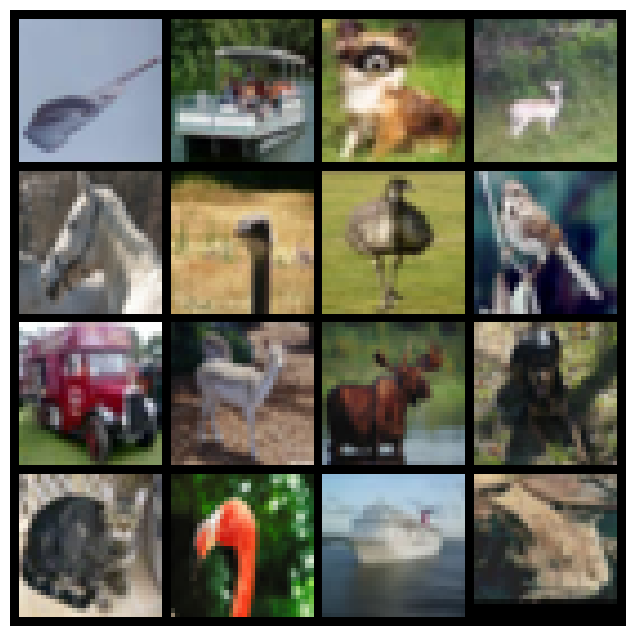

In [4]:
# Display sample images
data_iter = iter(dataloader)
images, _ = next(data_iter)
images = (images * 0.5 + 0.5).clamp(0, 1)  # Denormalize for visualization
grid = torchvision.utils.make_grid(images[:16], nrow=4)
plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0))
plt.axis("off")
plt.show()

# Step 2: Define the VAE

### Encoder Architecture:
The Encoder purpose is to compress input data into a latent space.

In Encoder architecture we have three convolutional layers which are increasing the output channels (32, 64, 128) and the final output of cnns of our encoder is a flattened vector.

after cnns and After flattening, two fully connected layers generate two vectors: 
* mu (mean of the latent distribution)
* logvar (log variance, which is used to calculate the standard deviation for reparameterization).


### Decoder Architecture:
the Decoder reconstructs the input from latent variables.

* Fully Connected Layer : Takes the latent space and reshapes it into a tensor that matches the shape expected by the transposed convolutional layers 128*4*4.
* Convolutional Transpose Layers: The decoder uses three transposed convolutional layers (similar to deconvolution), with the output channels decreasing from 128 to 64 to 32 (opposite), and finally producing a 3-channel output (RGB image). LeakyReLU is used as an activation function, except for the final layer, where Tanh is used to normalize the output to the range [-1, 1], which is commonly done for image generation.

### Logic of the architecture:
The architecture of this VAE is designed for efficient image compression and reconstruction. The latent dimension of 32 balances data compression and reconstruction quality. The encoder uses progressively larger convolutional layers to capture high-level features, while the decoder mirrors this structure to reconstruct the image. **The reparameterization trick allows for differentiable sampling from the latent space, enabling backpropagation**. The `Tanh` activation at the output ensures the image is within the [-1, 1] range. The architecture is regularized with KL divergence to ensure the latent space follows a normal distribution, preventing overfitting.

In [11]:
class VAE(nn.Module):
    def __init__(self, latent_dim=32):
        super(VAE, self).__init__()
        # Chosen to balance information compression and reconstruction quality.
        # A smaller dimension compresses more but might lose details, while a larger one retains more information.
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU()
        )
        self.fc_mu = nn.Linear(128 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(128 * 4 * 4, latent_dim)

        # Decoder
        self.fc_dec = nn.Linear(latent_dim, 128 * 4 * 4)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()  # Outputs in range [-1, 1]
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # Encode
        encoded = self.encoder(x).view(x.size(0), -1)
        mu = self.fc_mu(encoded)
        logvar = self.fc_logvar(encoded)

        # Reparameterization trick
        z = self.reparameterize(mu, logvar)

        # Decode
        decoded = self.fc_dec(z).view(-1, 128, 4, 4)
        decoded = self.decoder(decoded)
        return decoded, mu, logvar

# Step 3: Define Loss Function

### Explanation:
<img src="VAE-loss-function.png"/>
The first term, is the reconstruction loss, which measures how well the model reconstructs the input from the latent space.
The second term, is the KL divergence, which regularizes the latent space to ensure it follows a normal distribution.
In the code, we minimize the negative ELBO by combining the reconstruction loss (MSE) and the KL divergence, which together guide the model to learn a meaningful latent space and reconstruct the input data accurately.

In [12]:
def vae_loss(reconstructed, original, mu, logvar):
    reconstruction_loss = nn.functional.mse_loss(reconstructed, original, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return reconstruction_loss + kl_divergence

# Step 4: Train the VAE

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training on {device}")
vae = VAE(latent_dim=16).to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

num_epochs = 100

Training on cuda


Epoch 1, Loss: 229.0839


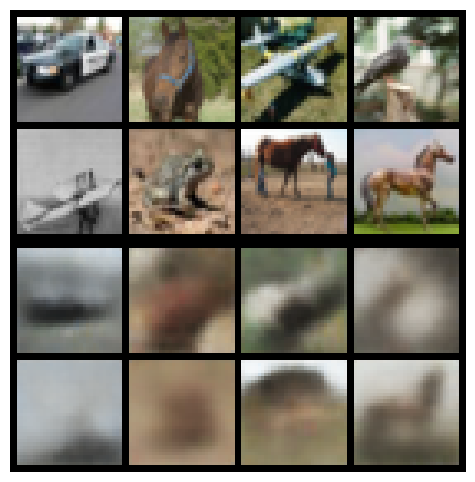

Epoch 2, Loss: 229.0207


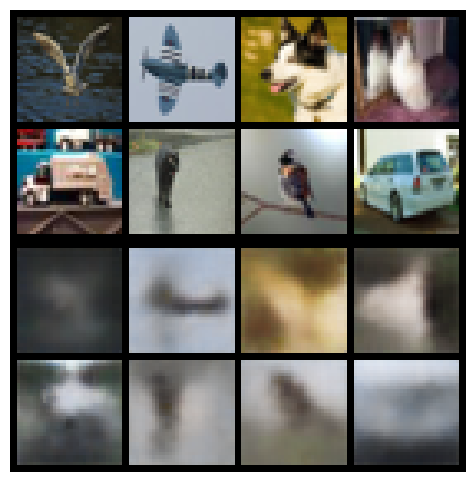

Epoch 3, Loss: 228.9488


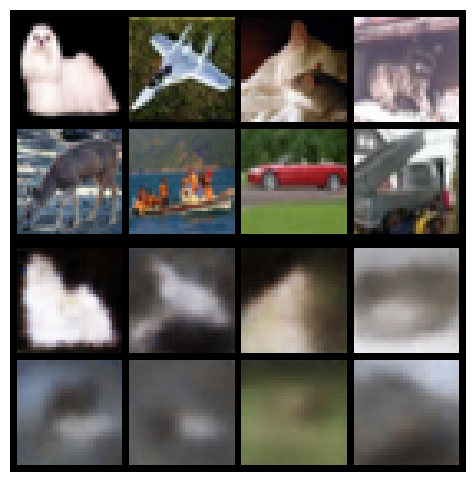

Epoch 4, Loss: 229.0208


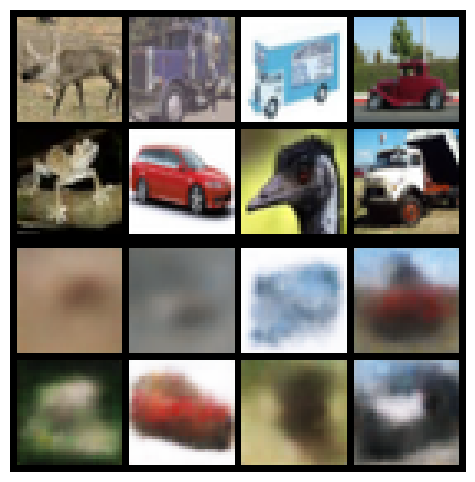

Epoch 5, Loss: 228.9163


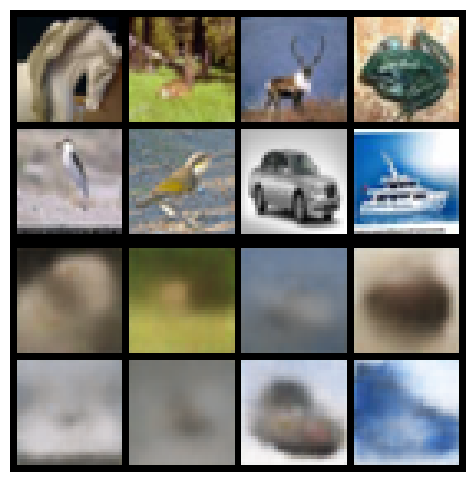

Epoch 6, Loss: 229.0240


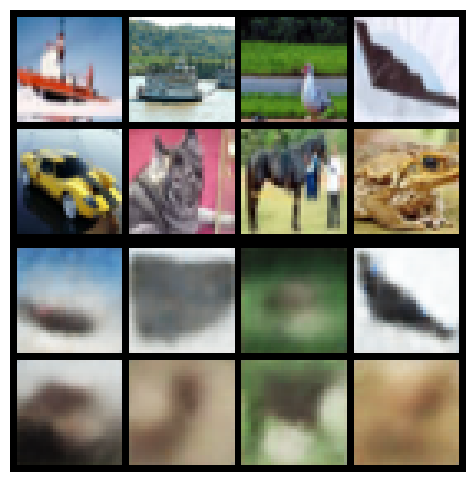

Epoch 7, Loss: 229.0616


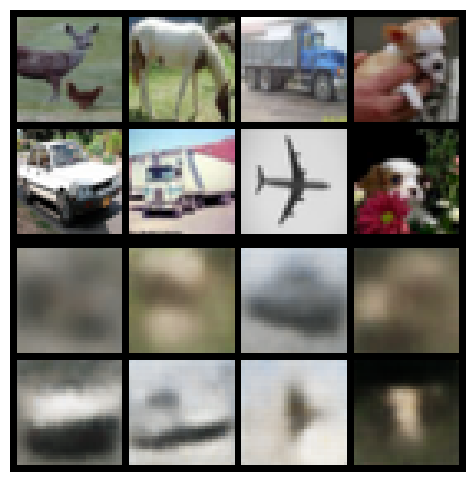

Epoch 8, Loss: 228.9157


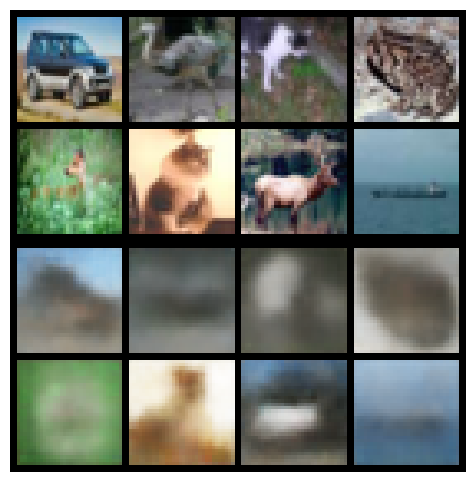

Epoch 9, Loss: 228.9521


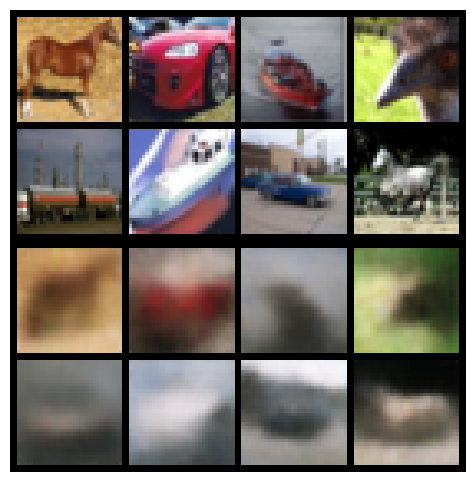

Epoch 10, Loss: 228.8969


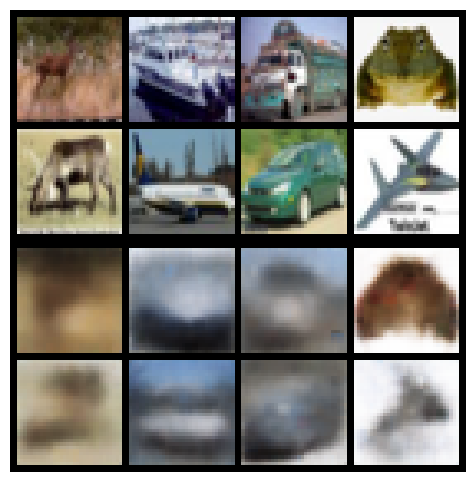

Epoch 11, Loss: 228.8685


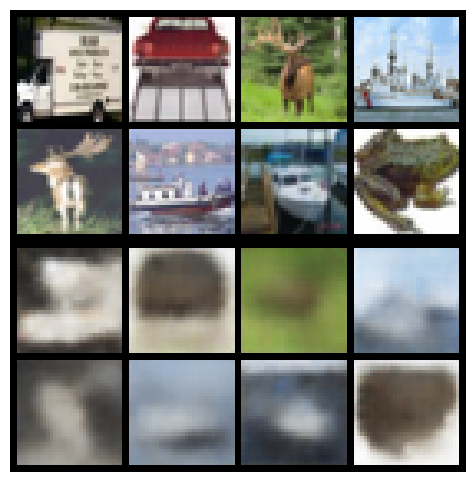

Epoch 12, Loss: 228.8712


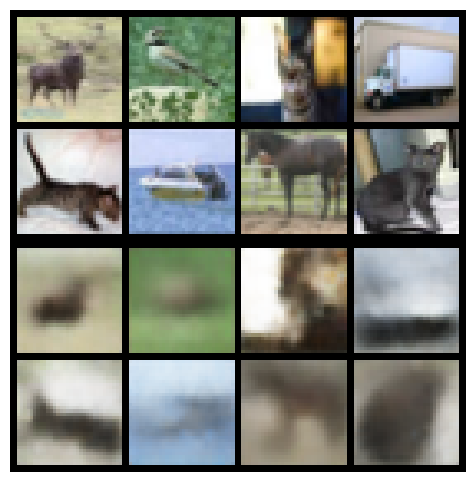

Epoch 13, Loss: 228.8017


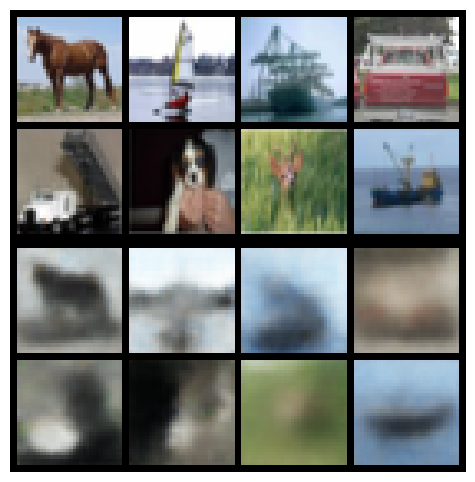

Epoch 14, Loss: 228.7925


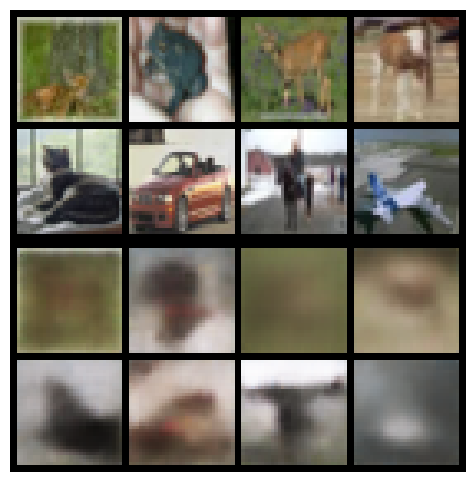

Epoch 15, Loss: 228.8637


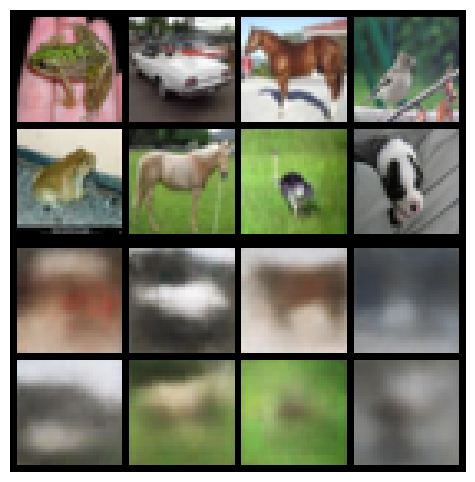

Epoch 16, Loss: 228.8053


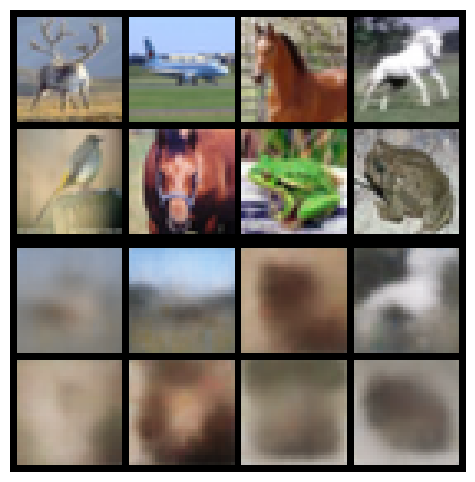

Epoch 17, Loss: 228.8298


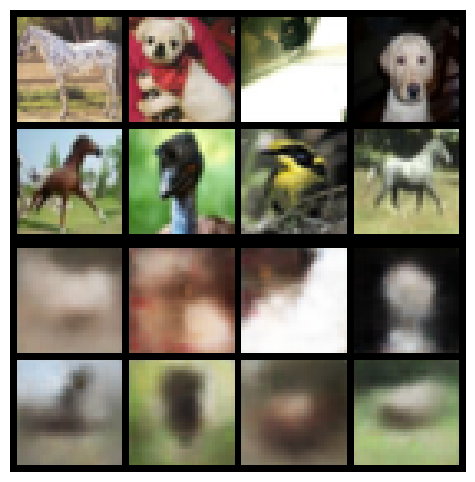

Epoch 18, Loss: 228.7747


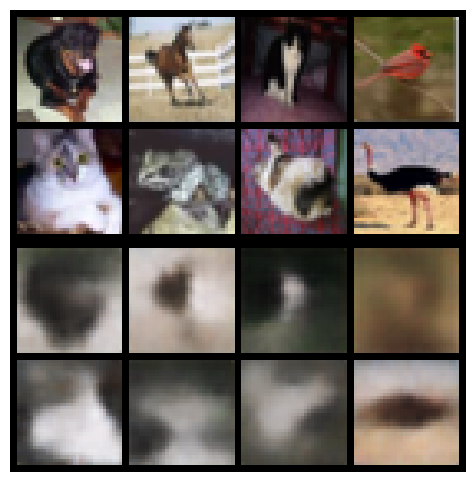

Epoch 19, Loss: 228.7576


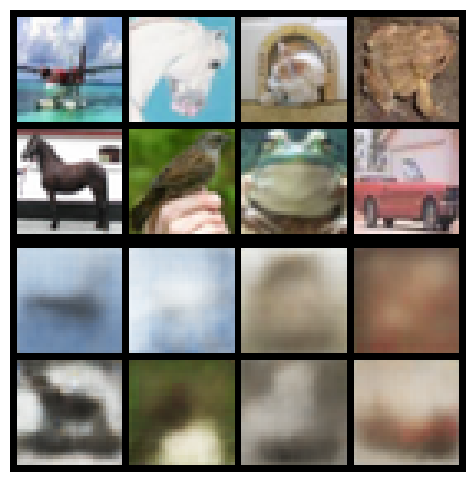

Epoch 20, Loss: 228.7724


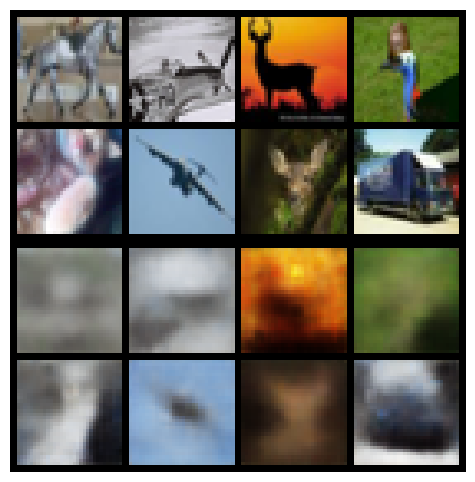

Epoch 21, Loss: 228.6226


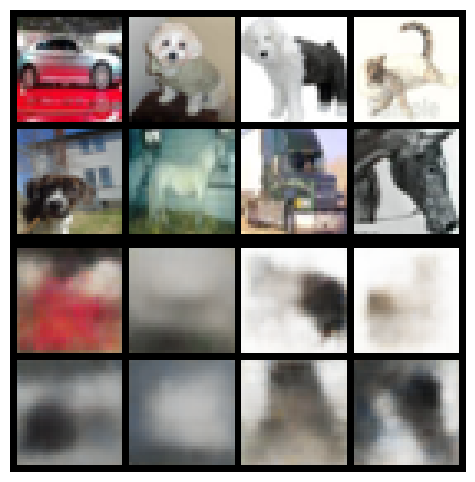

Epoch 22, Loss: 228.6647


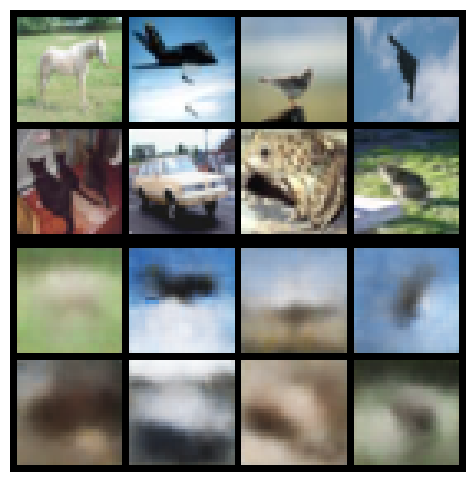

Epoch 23, Loss: 228.6641


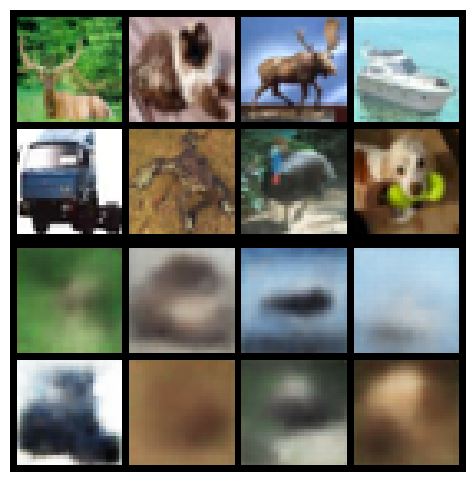

Epoch 24, Loss: 228.7543


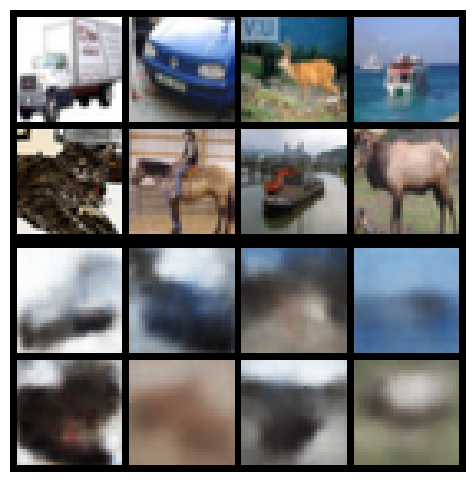

Epoch 25, Loss: 228.5878


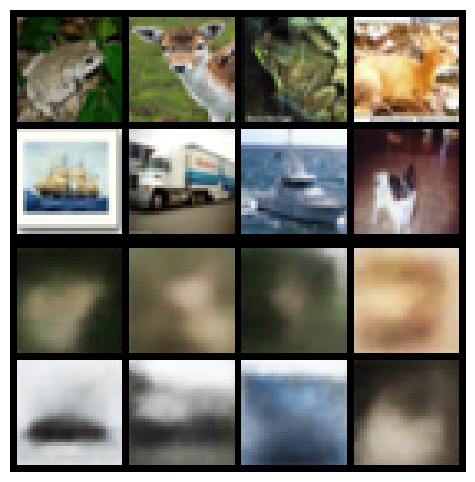

Epoch 26, Loss: 228.6388


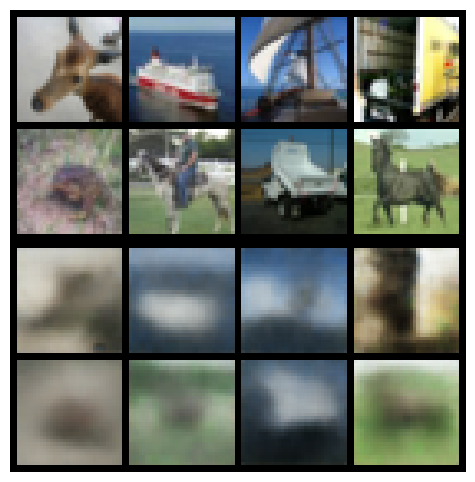

Epoch 27, Loss: 228.6576


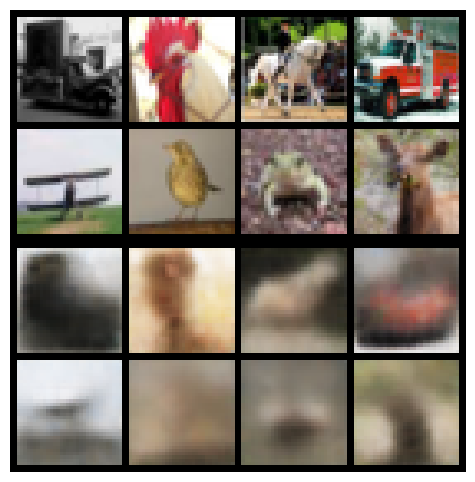

Epoch 28, Loss: 228.6402


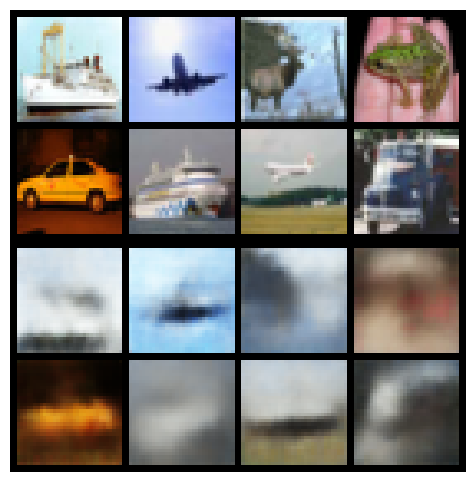

Epoch 29, Loss: 228.6786


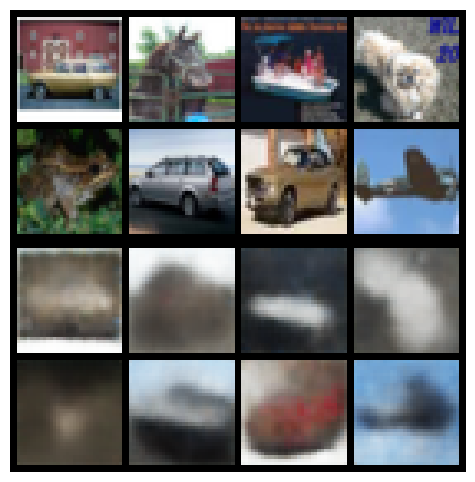

Epoch 30, Loss: 228.5458


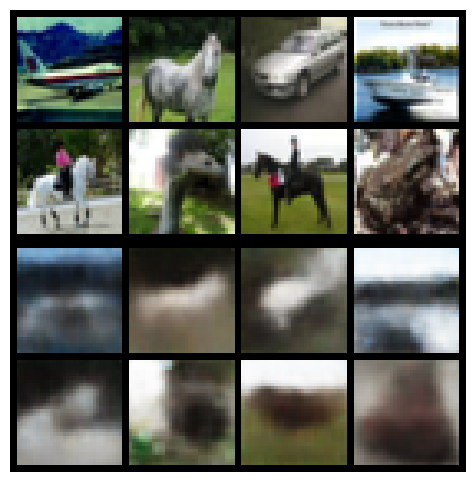

Epoch 31, Loss: 228.6204


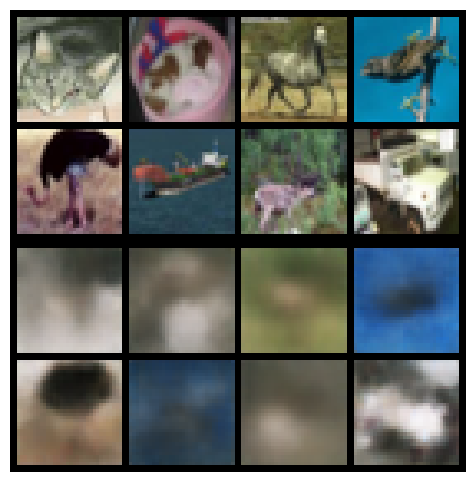

Epoch 32, Loss: 228.6415


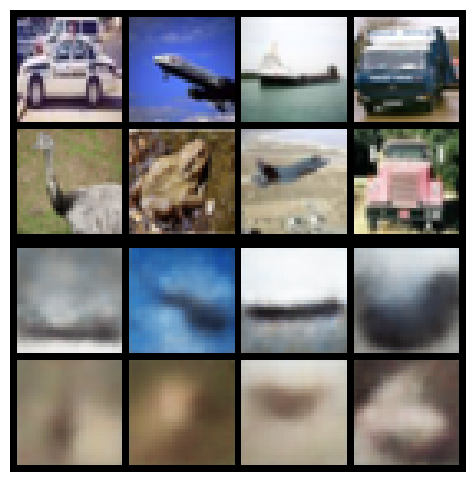

Epoch 33, Loss: 228.4684


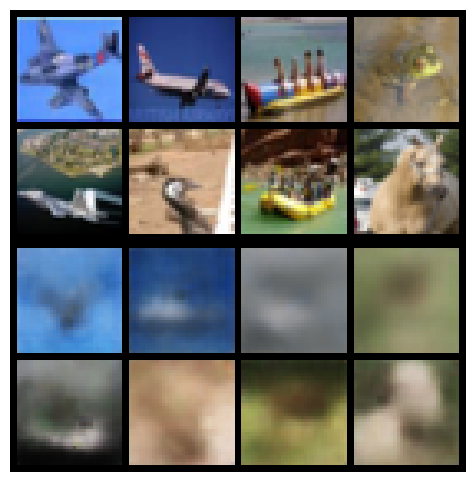

Epoch 34, Loss: 228.5620


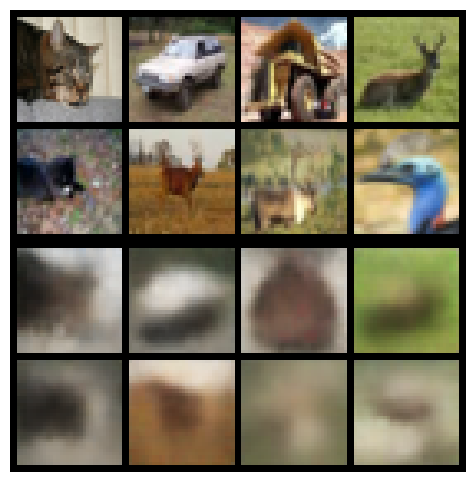

Epoch 35, Loss: 228.4829


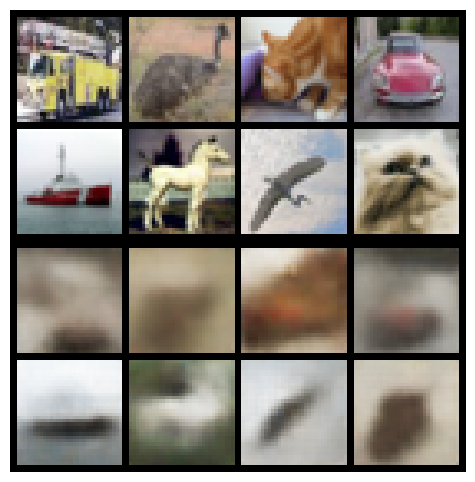

Epoch 36, Loss: 228.5455


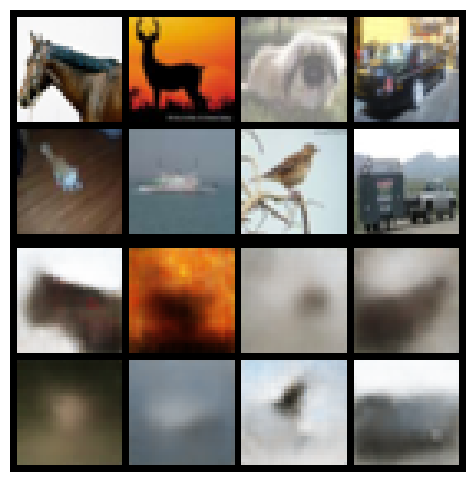

Epoch 37, Loss: 228.5216


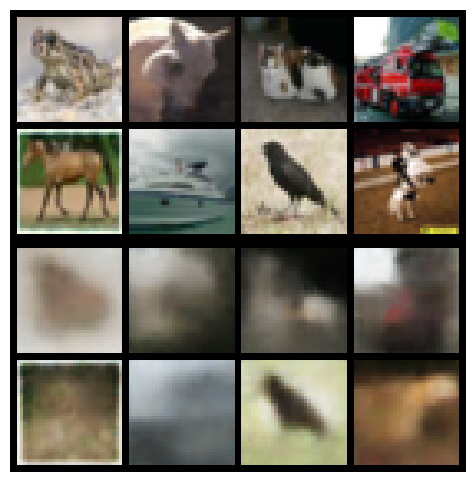

Epoch 38, Loss: 228.5908


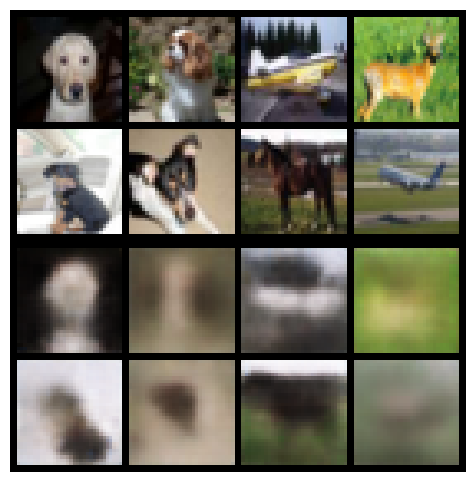

Epoch 39, Loss: 228.4183


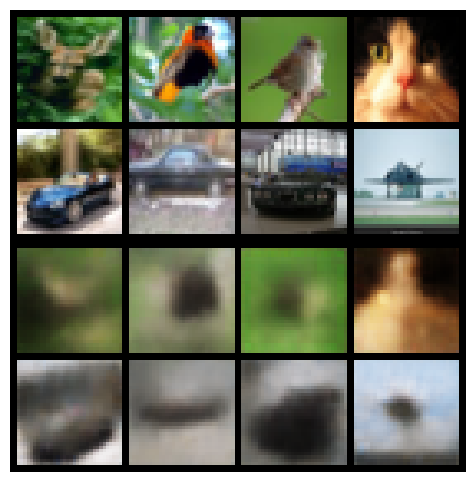

Epoch 40, Loss: 228.4617


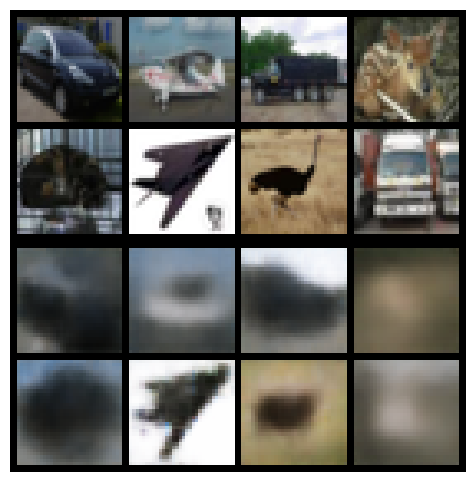

Epoch 41, Loss: 228.5206


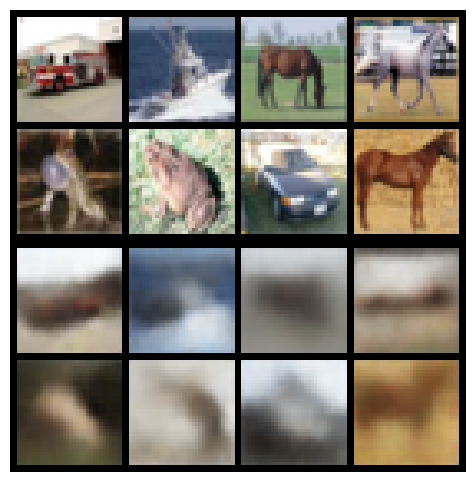

Epoch 42, Loss: 228.4440


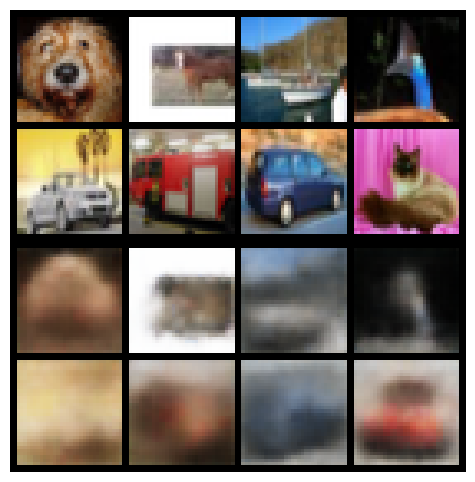

Epoch 43, Loss: 228.4758


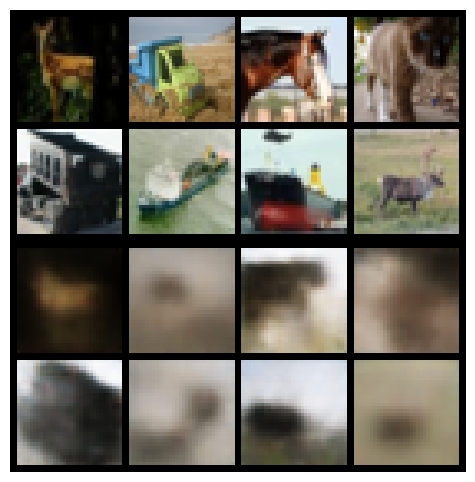

Epoch 44, Loss: 228.3479


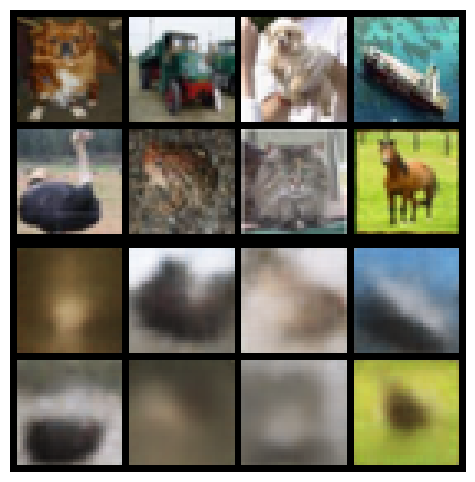

Epoch 45, Loss: 228.3774


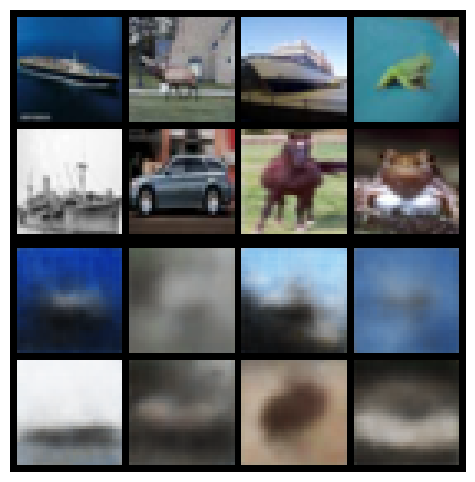

Epoch 46, Loss: 228.3227


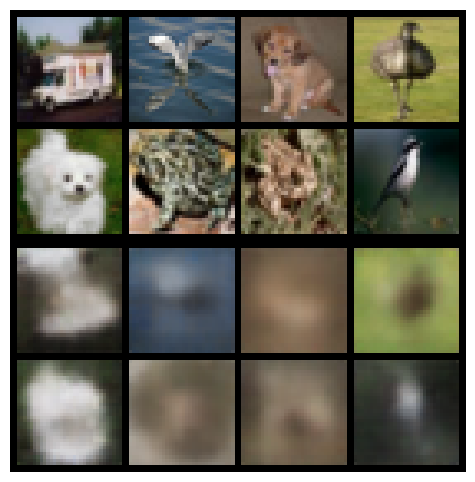

Epoch 47, Loss: 228.4311


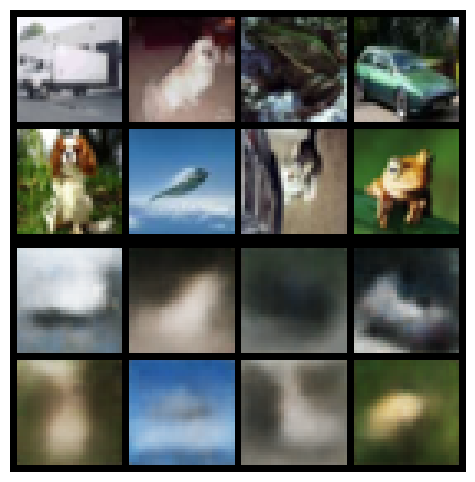

Epoch 48, Loss: 228.4524


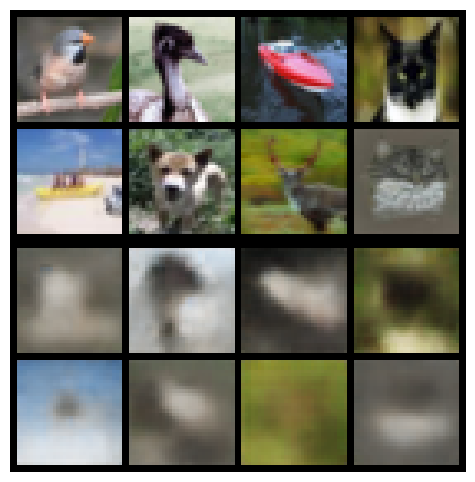

Epoch 49, Loss: 228.2733


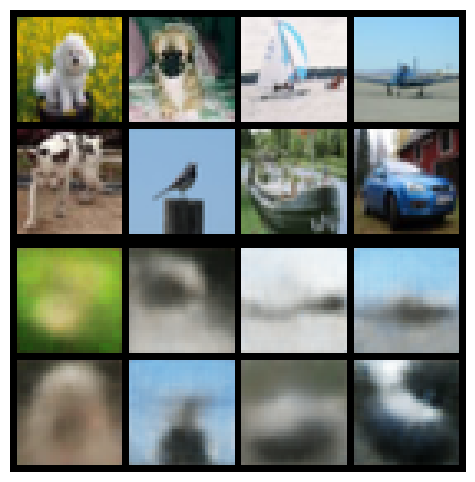

Epoch 50, Loss: 228.3290


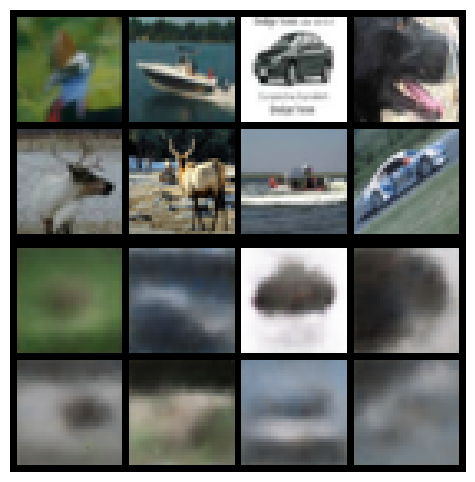

Epoch 51, Loss: 228.3368


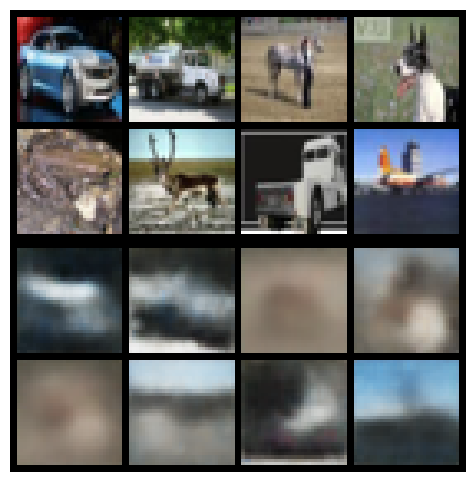

Epoch 52, Loss: 228.2940


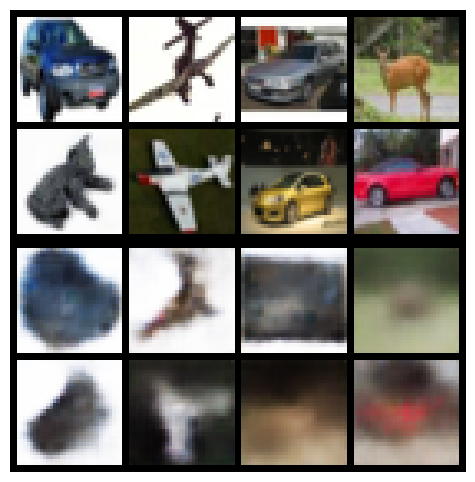

Epoch 53, Loss: 228.3379


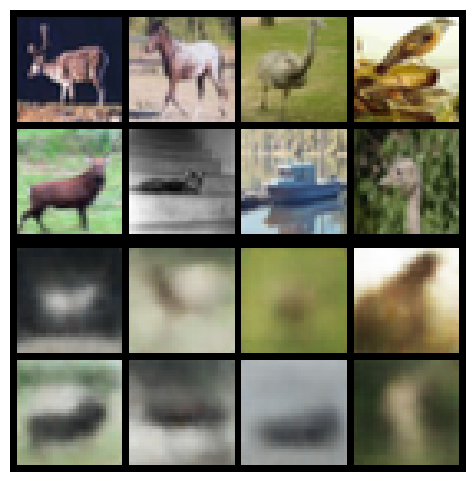

Epoch 54, Loss: 228.3443


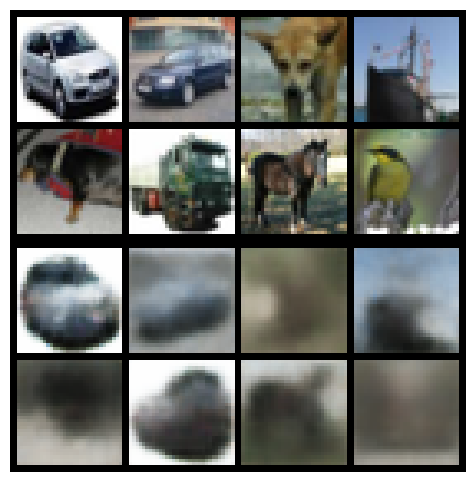

Epoch 55, Loss: 228.2696


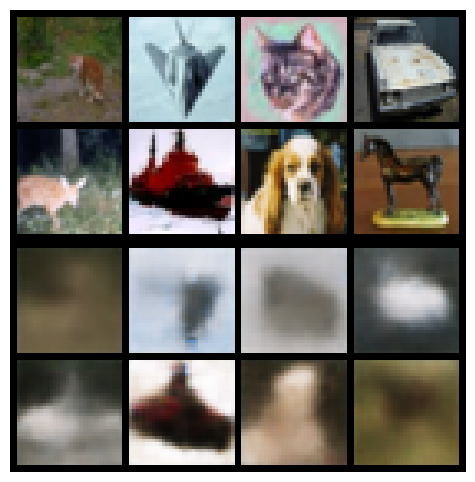

Epoch 56, Loss: 228.2392


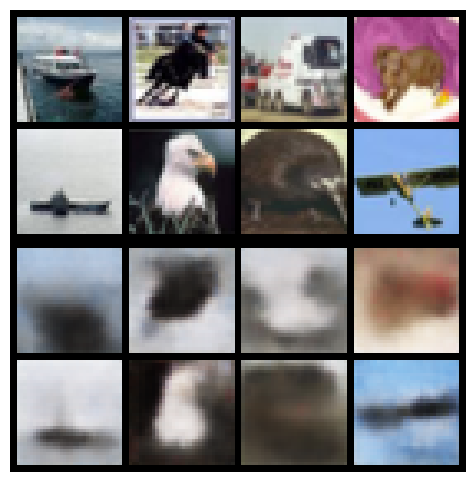

Epoch 57, Loss: 228.2623


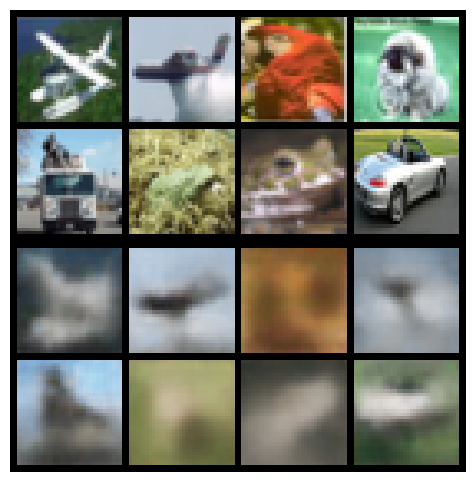

Epoch 58, Loss: 228.1888


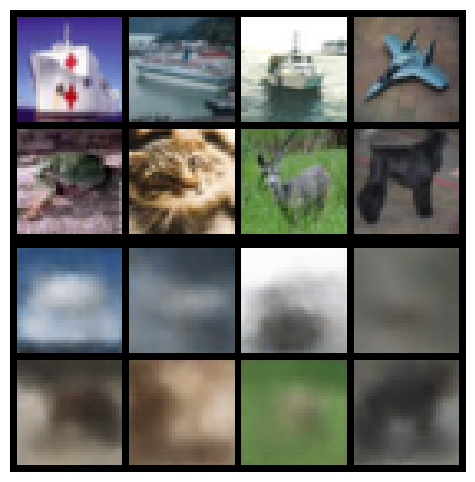

Epoch 59, Loss: 228.2999


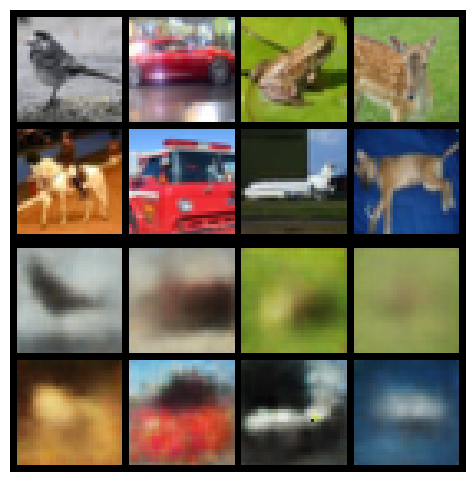

Epoch 60, Loss: 228.2477


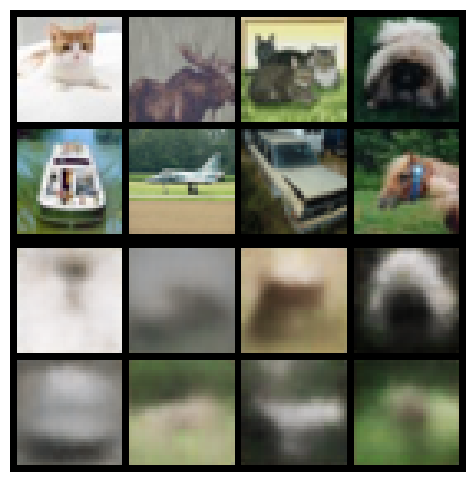

Epoch 61, Loss: 228.1801


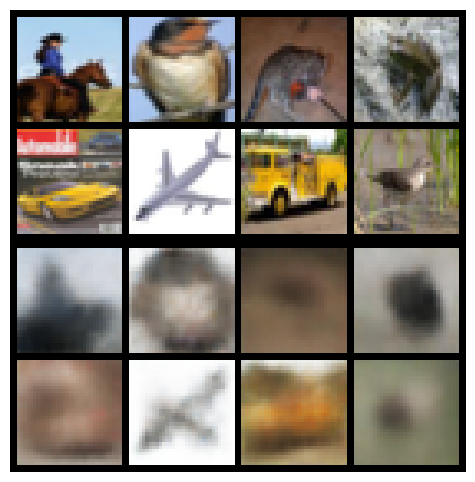

Epoch 62, Loss: 228.1787


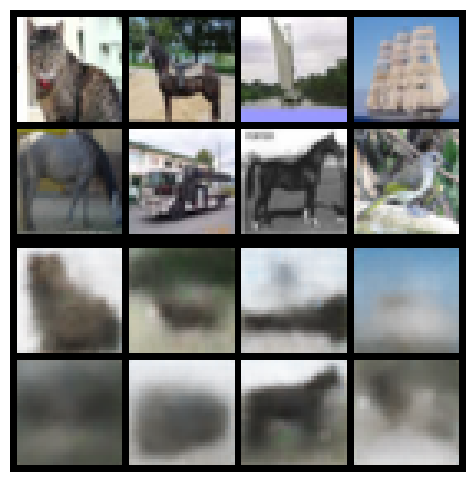

Epoch 63, Loss: 228.2172


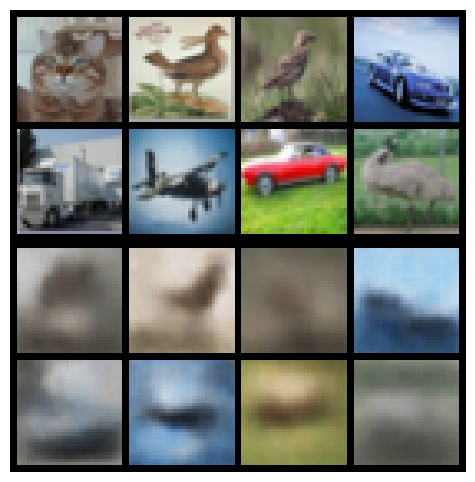

Epoch 64, Loss: 228.2316


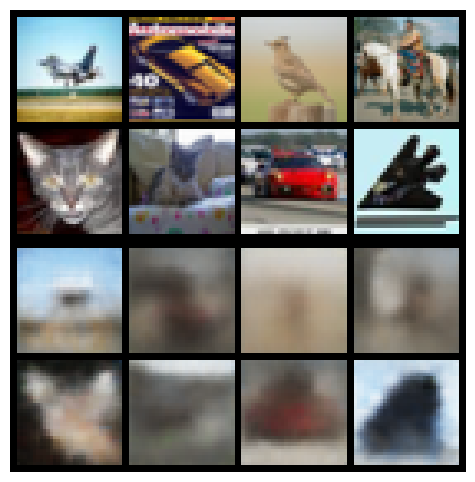

Epoch 65, Loss: 228.1684


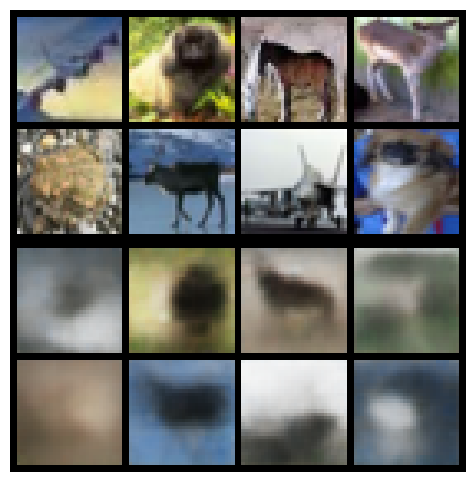

Epoch 66, Loss: 228.1557


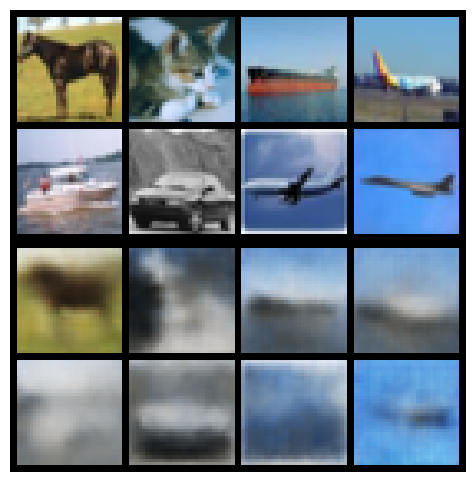

Epoch 67, Loss: 228.1017


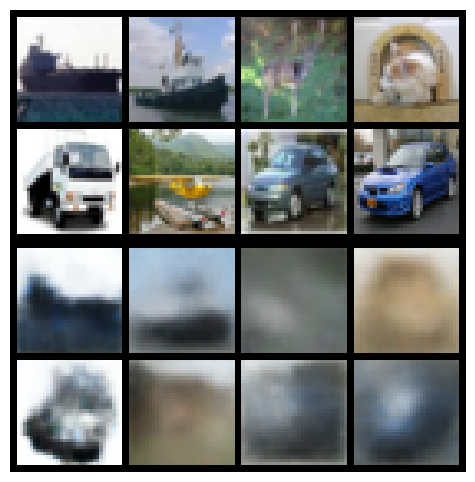

Epoch 68, Loss: 228.1462


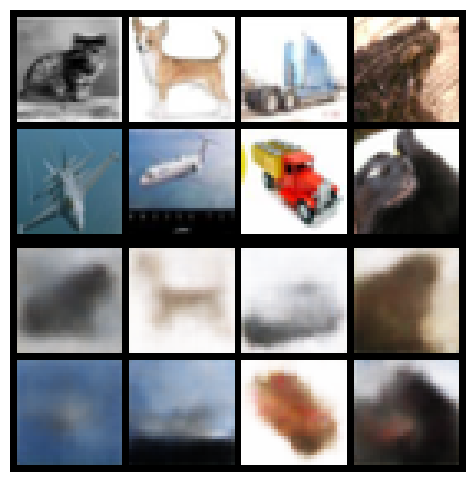

Epoch 69, Loss: 228.1333


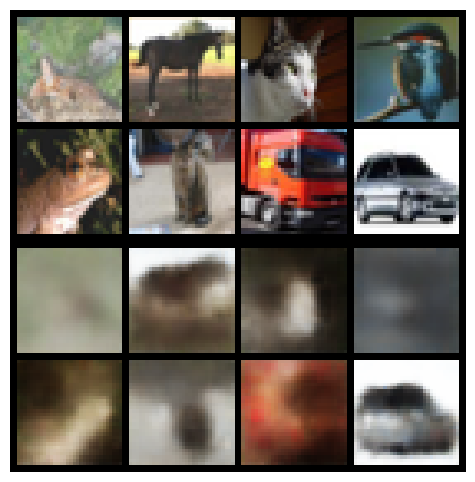

Epoch 70, Loss: 228.1090


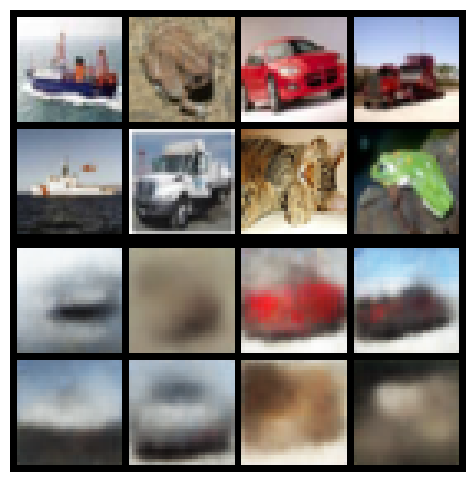

Epoch 71, Loss: 228.1094


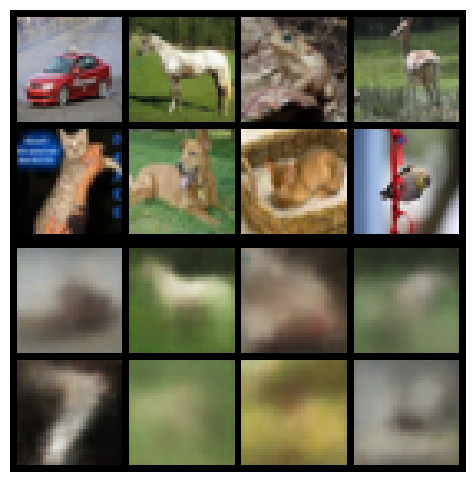

Epoch 72, Loss: 228.0834


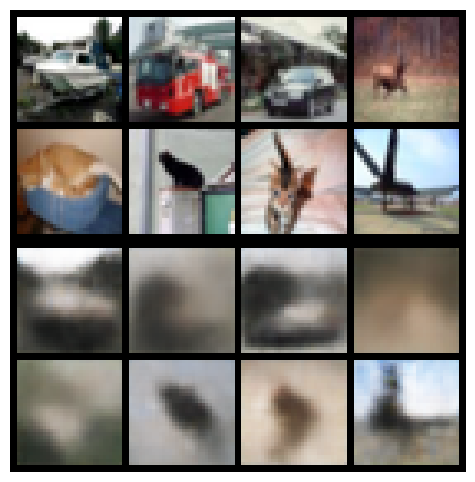

Epoch 73, Loss: 228.0941


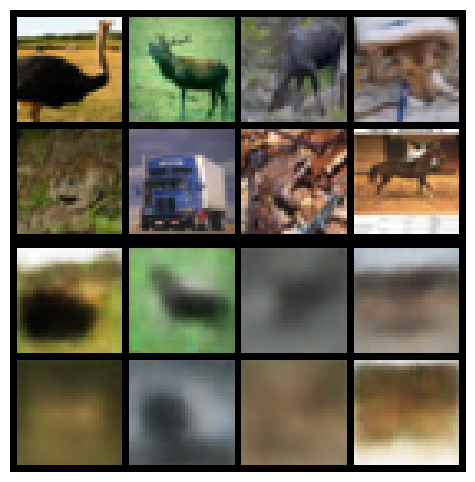

Epoch 74, Loss: 228.0619


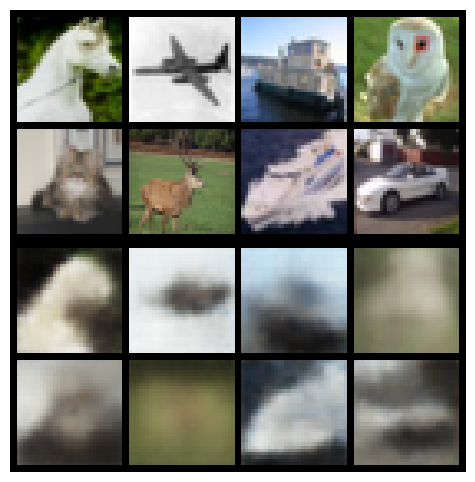

Epoch 75, Loss: 228.0666


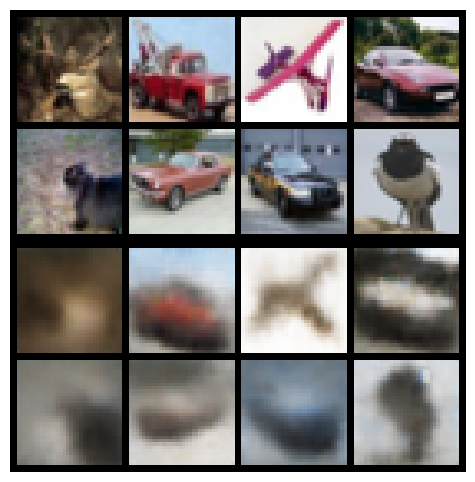

Epoch 76, Loss: 228.1471


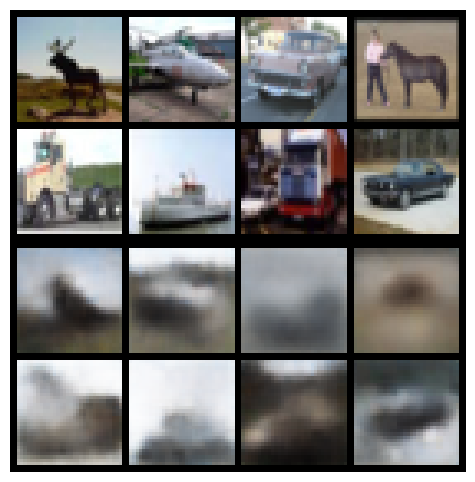

Epoch 77, Loss: 228.0295


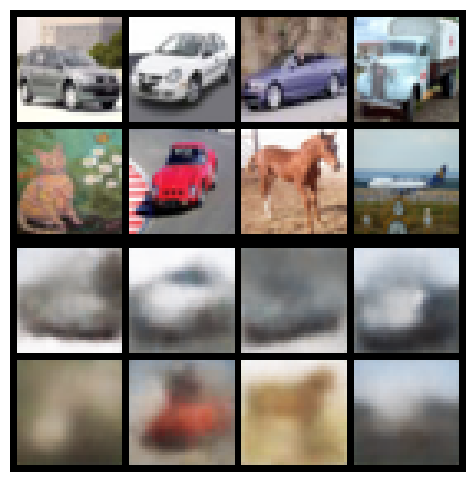

Epoch 78, Loss: 228.0482


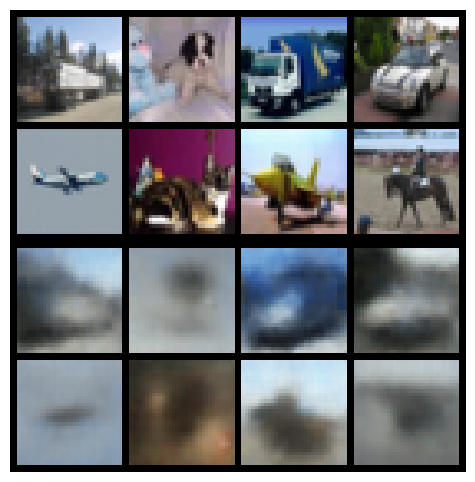

Epoch 79, Loss: 227.9637


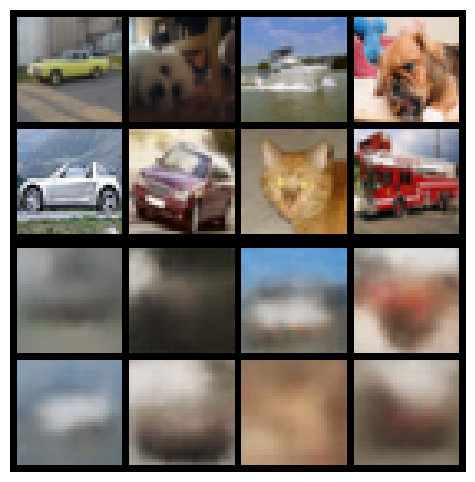

Epoch 80, Loss: 228.1275


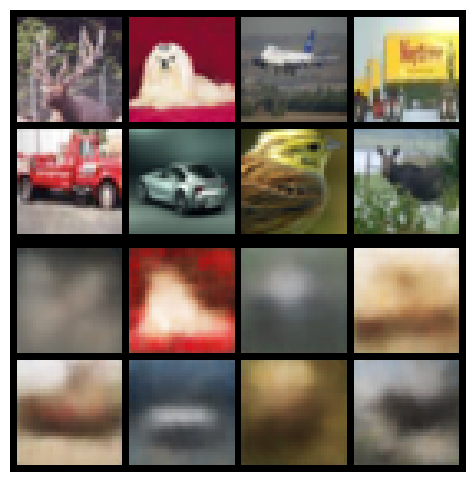

Epoch 81, Loss: 228.0324


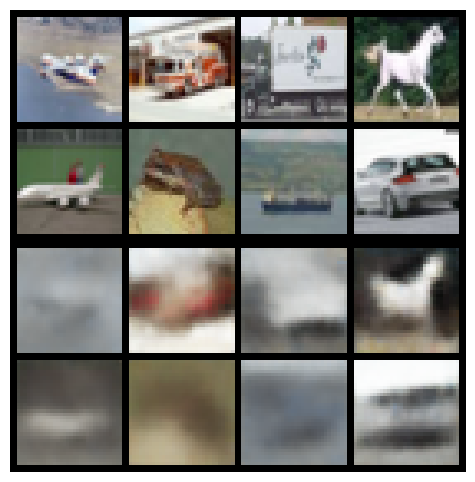

Epoch 82, Loss: 228.0292


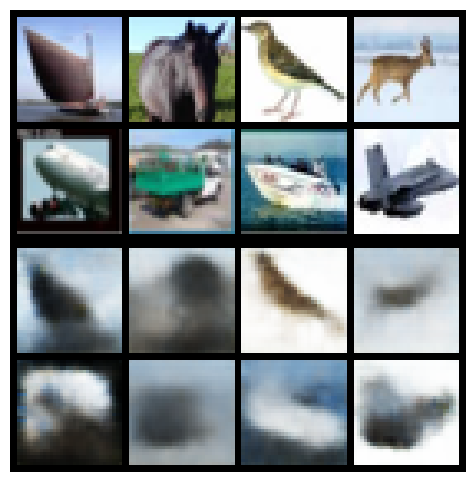

Epoch 83, Loss: 227.9873


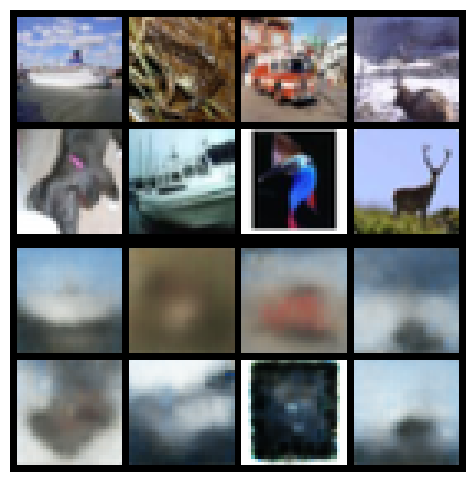

Epoch 84, Loss: 228.0703


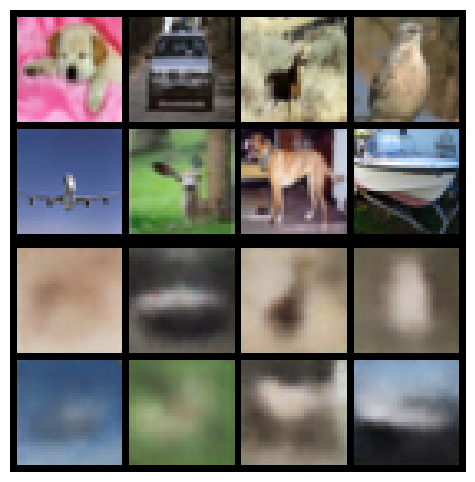

Epoch 85, Loss: 228.0249


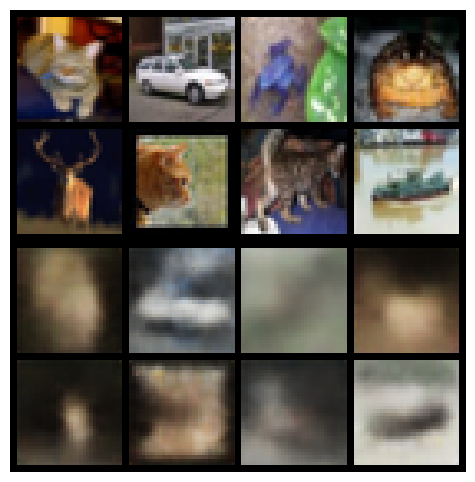

Epoch 86, Loss: 227.8958


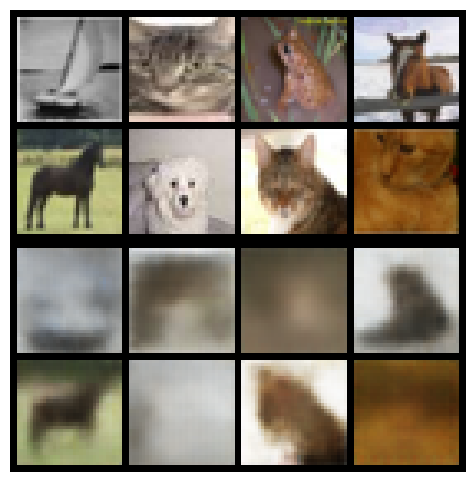

Epoch 87, Loss: 228.0361


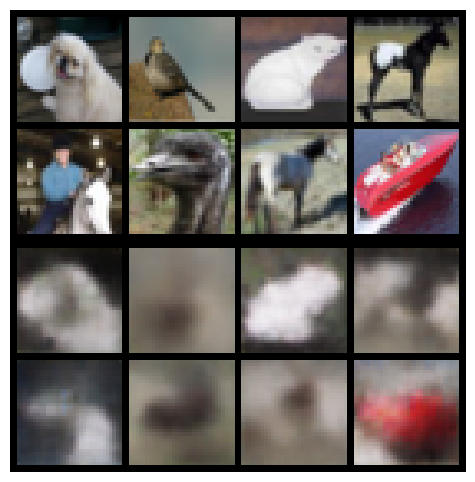

Epoch 88, Loss: 228.0195


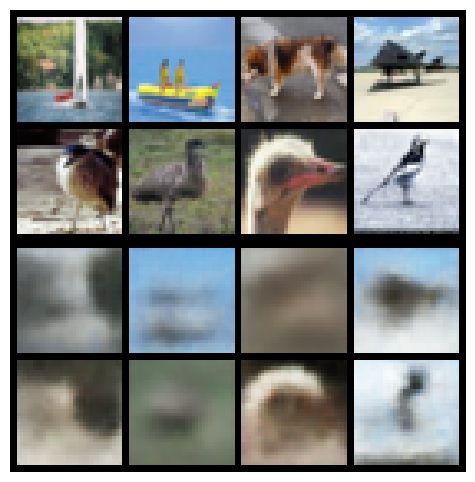

Epoch 89, Loss: 227.9044


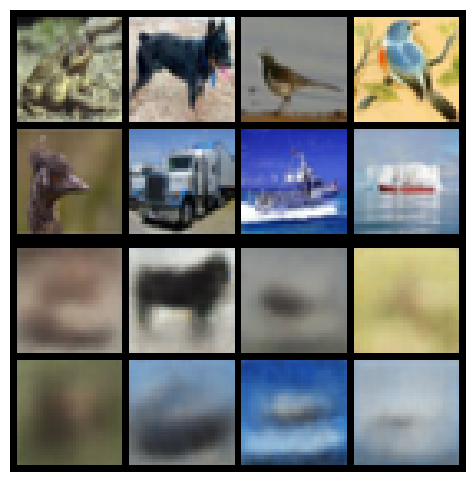

Epoch 90, Loss: 227.9071


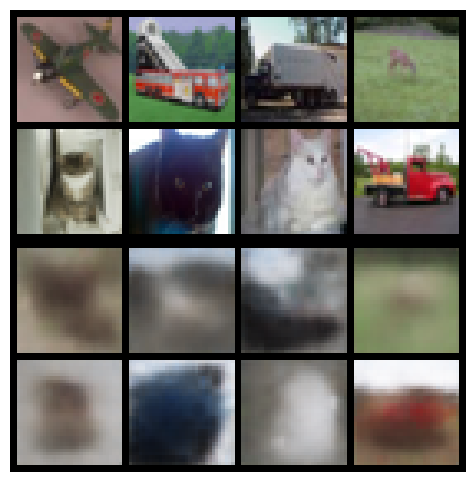

Epoch 91, Loss: 227.9348


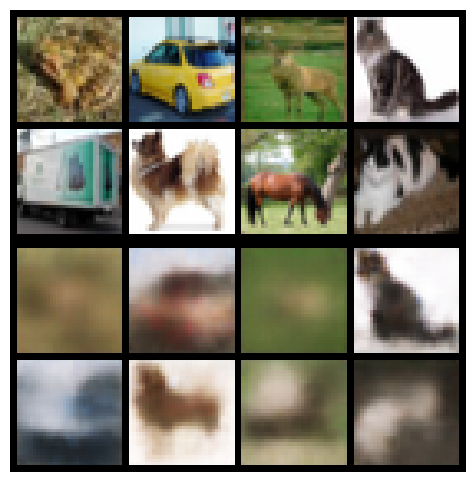

Epoch 92, Loss: 228.0287


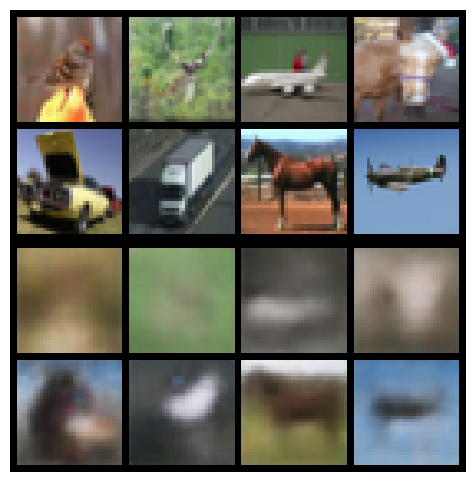

Epoch 93, Loss: 227.9234


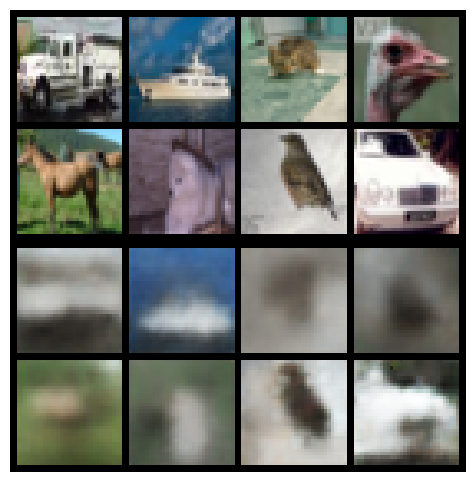

Epoch 94, Loss: 227.9156


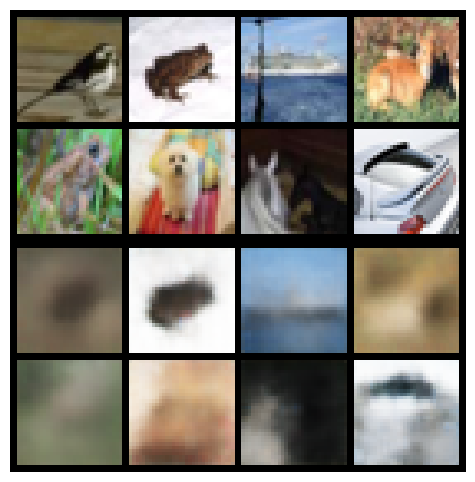

Epoch 95, Loss: 227.9106


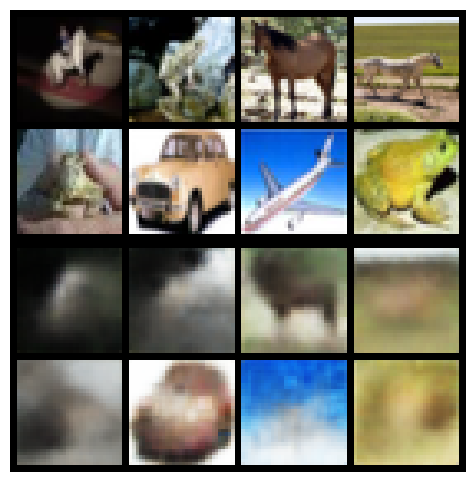

Epoch 96, Loss: 227.8932


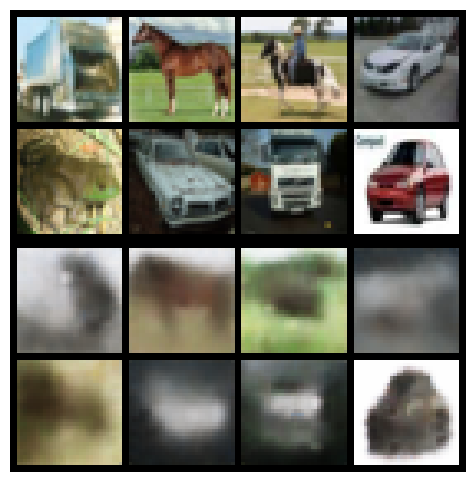

Epoch 97, Loss: 227.9341


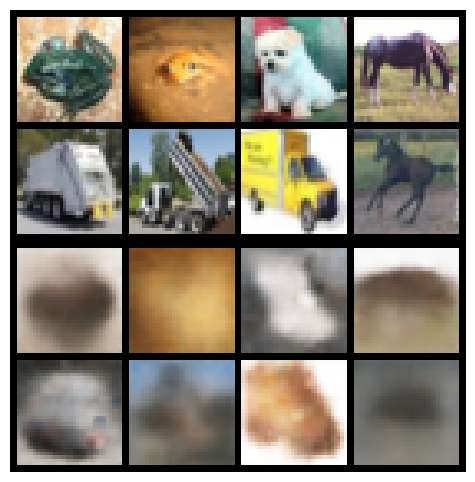

Epoch 98, Loss: 227.9045


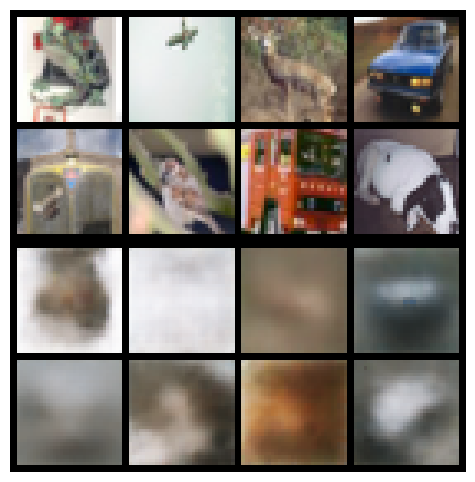

Epoch 99, Loss: 227.8713


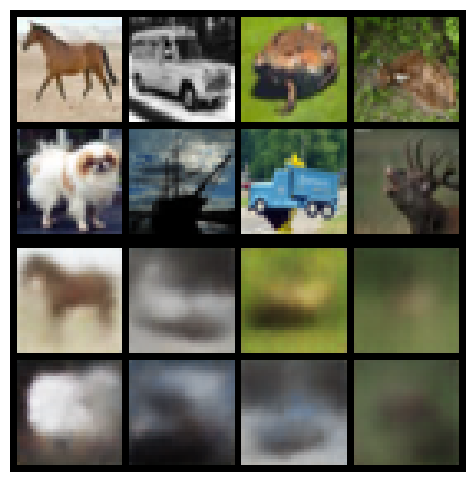

Epoch 100, Loss: 227.9414


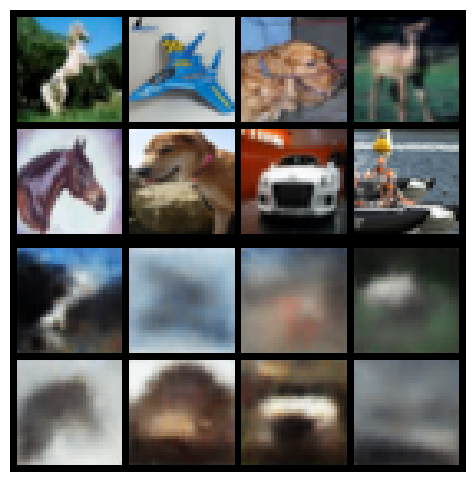

In [13]:
for epoch in range(num_epochs):
    vae.train()
    train_loss = 0

    for images, _ in dataloader:
        images = images.to(device)

        optimizer.zero_grad()
        reconstructed, mu, logvar = vae(images)
        loss = vae_loss(reconstructed, images, mu, logvar)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    print(f"Epoch {epoch + 1}, Loss: {train_loss / len(dataloader.dataset):.4f}")

    # Visualize some reconstructed images
    vae.eval()
    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            reconstructed, _, _ = vae(images)
            break

        images = (images * 0.5 + 0.5).clamp(0, 1)
        reconstructed = (reconstructed * 0.5 + 0.5).clamp(0, 1)

        grid = torch.cat([
            torchvision.utils.make_grid(images[:8], nrow=4),
            torchvision.utils.make_grid(reconstructed[:8], nrow=4)
        ], dim=1)

        plt.figure(figsize=(12, 6))
        plt.imshow(grid.permute(1, 2, 0).cpu())
        plt.axis("off")
        plt.show()
# save the model
torch.save(vae.state_dict(), "vae.pth")

## Resources 
1. https://www.youtube.com/watch?v=vy8q-WnHa9A
2. https://www.youtube.com/watch?v=HBYQvKlaE0A
3. https://medium.com/@rekalantar/variational-auto-encoder-vae-pytorch-tutorial-dce2d2fe0f5f